In [1]:
%load_ext skip_kernel_extension

import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)


In [2]:
import keras_tuner as kt
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [4]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = False
SKIP_RETRAIN_ED_LSTM = True

## Loading Data

In [5]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [6]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


# Multistep LSTM

Scale the input data

In [7]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [8]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
model_type = 'LSTM'
namespace = 'MS_LSTM_LOAD_HPT'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [9]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [10]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(168, 72, 26) (168, 24)


Define LSTM Model

In [11]:
def build_model_LSTM(hp):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential()
  
  model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), return_sequences=True,input_shape=(None, n_features), stateful=False)) 
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(hp.Float('Dropout',min_value=0.1,max_value=0.4,step=0.1)))
  
  for i in range(hp.Int('n_layers',1,4,1)):
    model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), return_sequences=True, stateful=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('Dropout',min_value=0.1,max_value=0.4,step=0.1)))
    
  model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), stateful=False))
  
  model.add(layers.Dense(hp.Int('Neurons',min_value=16,max_value=96,step=16), kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),)
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(n_outputs))                     
  
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

In [12]:
tuner = kt.RandomSearch(
    build_model_LSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial = 1,
    directory = "./hpt_LSTM/",
    project_name="Load")
tuner.search_space_summary()


INFO:tensorflow:Reloading Oracle from existing project ./hpt_LSTM/DDE_3\oracle.json
INFO:tensorflow:Reloading Tuner from ./hpt_LSTM/DDE_3\tuner0.json
Search space summary
Default search space size: 3
Neurons (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': None}
Dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}


In [13]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{model_type}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [14]:
num_epochs = 150
batch_size = 32

In [15]:
tuner.search(data_x_train,data_y_train,epochs=150,validation_data=(data_x_val,data_y_val),batch_size=batch_size,callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary()

Results summary
Results in ./hpt_LSTM/DDE_3
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.4
n_layers: 4
Score: 9862256.0
Trial summary
Hyperparameters:
Neurons: 96
Dropout: 0.30000000000000004
n_layers: 4
Score: 11033387.0
Trial summary
Hyperparameters:
Neurons: 64
Dropout: 0.4
n_layers: 1
Score: 11300748.0
Trial summary
Hyperparameters:
Neurons: 48
Dropout: 0.1
n_layers: 2
Score: 11530967.0
Trial summary
Hyperparameters:
Neurons: 96
Dropout: 0.2
n_layers: 1
Score: 11773079.0
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.1
n_layers: 1
Score: 12437209.0
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.30000000000000004
n_layers: 1
Score: 12732465.0
Trial summary
Hyperparameters:
Neurons: 16
Dropout: 0.4
n_layers: 2
Score: 14758591.0
Trial summary
Hyperparameters:
Neurons: 32
Dropout: 0.2
n_layers: 3
Score: 17999762.0
Trial summary
Hyperparameters:
Neurons: 16
Dropout: 0.30000000000000004
n_layers: 1


In [17]:
best_models = tuner.get_best_models()
best_hps = tuner.get_best_hyperparameters(5)

In [18]:
best_hps[0]

In [19]:
%%skip $SKIP_RETRAIN_LSTM
model_LSTM= build_model_LSTM(best_hps[1])
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

Epoch 1/150
545/545 [==============================] - 25s 36ms/step - loss: 828600000.0000 - mae: 28428.5254 - val_loss: 900689664.0000 - val_mae: 29591.2109
Epoch 2/150
545/545 [==============================] - 18s 34ms/step - loss: 819652544.0000 - mae: 28287.9160 - val_loss: 879350144.0000 - val_mae: 29246.5625
Epoch 3/150
545/545 [==============================] - 18s 33ms/step - loss: 803455232.0000 - mae: 28023.7031 - val_loss: 866830656.0000 - val_mae: 29034.6309
Epoch 4/150
545/545 [==============================] - 18s 33ms/step - loss: 781707200.0000 - mae: 27657.7578 - val_loss: 826353152.0000 - val_mae: 28367.0781
Epoch 5/150
545/545 [==============================] - 18s 34ms/step - loss: 755834816.0000 - mae: 27205.2773 - val_loss: 776203712.0000 - val_mae: 27466.4805
Epoch 6/150
545/545 [==============================] - 18s 33ms/step - loss: 726603968.0000 - mae: 26676.9434 - val_loss: 720951488.0000 - val_mae: 26419.1641
Epoch 7/150
545/545 [=========================

Evaluate the training process

In [20]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

<string>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


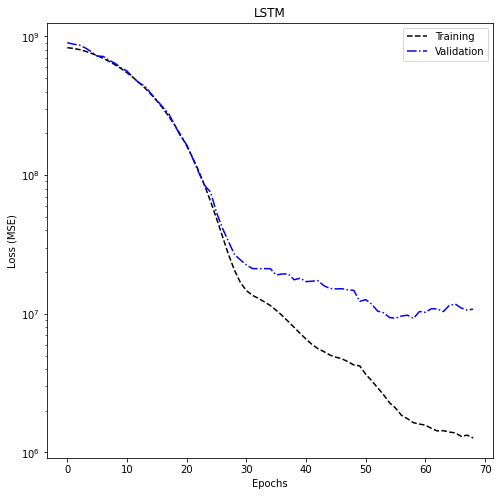

In [21]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,model_type,f'./{model_type}/learningcurve_{namespace}.png')
fig.show()

Load best model

In [22]:
#Calling back the best model:
model_best_MS_LSTM = keras.models.load_model(f"./{model_type}/my_best_model_{namespace}.h5")
model_best_MS_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 96)          47232     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 96)          384       
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 96)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 96)          74112     
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 96)          384       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 96)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 96)         

In [23]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))

Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]


In [24]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-25-9e430721b3b7>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


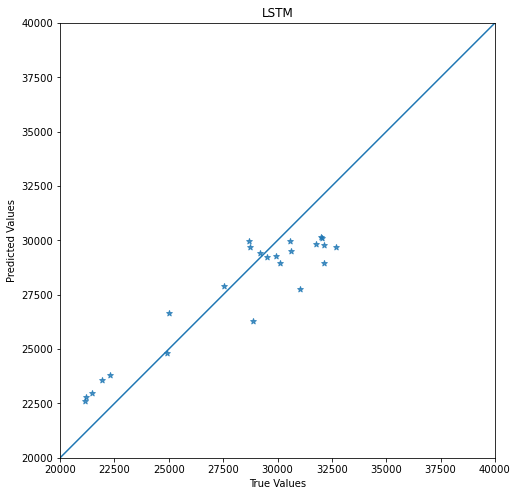

In [25]:
fig = plot_accuracy(eval_df,model_type,f'./{model_type}/accuracy_{namespace}.png')
fig.show()

<ipython-input-26-7c3e59406e1f>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


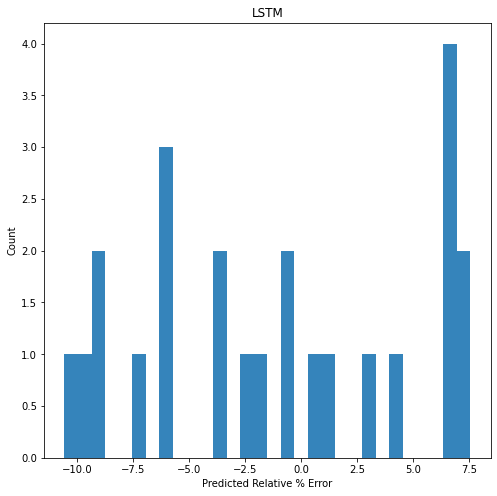

In [26]:
fig = plot_error_variations(eval_df,model_type,f'./{model_type}/error_variations_{namespace}.png')
fig.show()

In [27]:
#Calculating the mean absolutepercentage error:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

nan

In [28]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.80


<ipython-input-29-60dd1e0473df>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


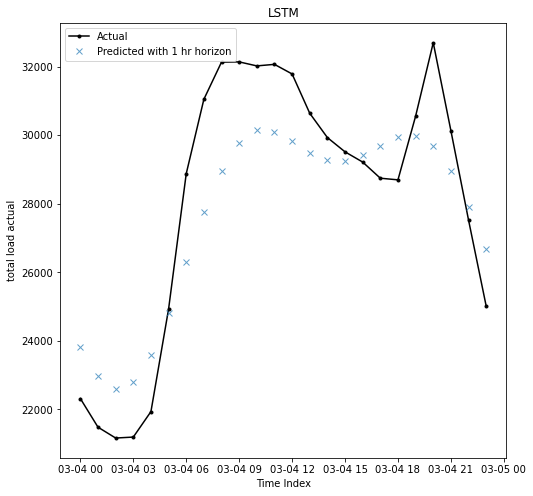

In [29]:
fig = plot_predictions(eval_df,1,model_type,feature,f'./{model_type}/predictions_{namespace}.png')
fig.show()

In [30]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [31]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [32]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.45
